# Breast cancer prediction

## Introduction

In this project I will look at a dataset of patient data relating to breast cancer, which is available on Kaggle as the [Wisconsin Breast Cancer dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

The dataset features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image in the 3-dimensional space is that described in: K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34.

The dataset was released in November 1995 and the original source can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). 

An example of images of cells that this data comes from of both malignant and benign tumors can be seen below.

![title](img/bc_cells.png)

Traditionally one of the main ways you could diagnose if a tumor is malignant or benign is to take a biopsy of a breast mass and then visually examine cell nuclei under a microscope. A trained specialist can then decide if there is cancer or not.

We can see here in the example above that the image on the left belongs to a patient who was diagnosed with a benign tumor, and the image on the right belong to a patient who was diagnosed with a malignant tumor.

The dataset we have consists of 32 features which relate to these types of images & cells and are the following:

- ID number 
- Diagnosis (M = malignant, B = benign) 

Features 3-32 are ten real-valued features are computed for each cell nucleus: 

- a) radius (mean of distances from center to points on the perimeter) 
- b) texture (standard deviation of gray-scale values) 
- c) perimeter 
- d) area 
- e) smoothness (local variation in radius lengths) 
- f) compactness (perimeter^2 / area - 1.0) 
- g) concavity (severity of concave portions of the contour) 
- h) concave points (number of concave portions of the contour) 
- i) symmetry 
- j) fractal dimension ("coastline approximation" - 1)

The mean, standard error (se) and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

We can see from the image examples that it is visually possible to distinguish between malignant and benign tumor cells. It is hoped that the data derived from these images of the cells is able to capture the differences between these types of cells.

In this project, I will aim to develop a machine learning model that will aim to predict Malignant tumors with the highest accuracy.

https://github.com/pranath/predict_charity_donors/blob/master/finding_donors.ipynb

https://pechyonkin.me/portfolio/breast-cancer-diagnostics/

https://www.inertia7.com/projects/95

## Import libraries

Let us first import the libraries we will need for analysis and developing our model.

In [145]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D  
import sklearn
from sklearn.manifold import TSNE
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
import kmapper as km
import seaborn as sns
import time

%matplotlib inline

## Load data

In [100]:
# Load the Census dataset
bcancer_df = pd.read_csv("data.csv")

## Initial data exploration

We will now take an initial look at the dataset, its values and structure.

In [101]:
# For reproducability of the results
np.random.seed(42)
# Observe first few rows
bcancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Ok we can see there are quite a range of continous values for each of the features. Also note something odd, the final column is called 'Unnamed: 32' and is full of nan's - it's not mentioned in the dataset description and looks like some kind of format error in the dataset csv. Let's note that for later in our cleaning phase.

Lets compute some key stats for each of the features to get a feel for them.

In [102]:
# Compute key stats for each feature
bcancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


Ok quite a bit of variation in the scale and range of values (note also very variable std. dev.) we will need scaling of features later before we feed the data to our model.

Lets now check for completeness of data, which according to the dataset description should not have any missing values.

In [103]:
# Check for nans
bcancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Ok all looks complete (bar our 'Unnamed: 32' column which we will drop later in our cleaning phase).

Let's now check the proportions of the dataset between benign & malignant target classes.

In [104]:
bcancer_df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

That's in line with our expectations from the dataset description, however it is encoded as a string/categorical value and we will need to make that numeric before feeding into our ML model.

## Clean data

So we have just a couple of cleaning steps identified previously, which are to convert the diagnosis field into numeric values and to drop the id and 'Unnamed: 32' columns.

In [106]:
# Encode the 'diagnosis' feature to numerical values
bcancer_clean_df = bcancer_df.replace(['B', 'M'], [0, 1])

In [107]:
# Remove last column 
bcancer_clean_df = bcancer_clean_df.drop(bcancer_df.columns[len(bcancer_df.columns)-1], axis=1)
# Remove id column
bcancer_clean_df = bcancer_clean_df.drop(['id'], axis=1)
# Show first few rows
bcancer_clean_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Further data exploration

Ok now we have cleaned up our dataset, we are in a better position to look more closely at it.

### Compare distribution of values for each feature between benign & malignent tumor sub-groups

Let's do a univariate exploration of each of the numerical features, but by dividing the dataset into sub-groups for 'diagnosis' i.e. malignant and benign sub groups, and compare the distributions for each sub groups to see what patterns there are.

In [108]:
# Split dataset into those with malignent and those with benign tumors
malignent_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==1]
benign_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==0]

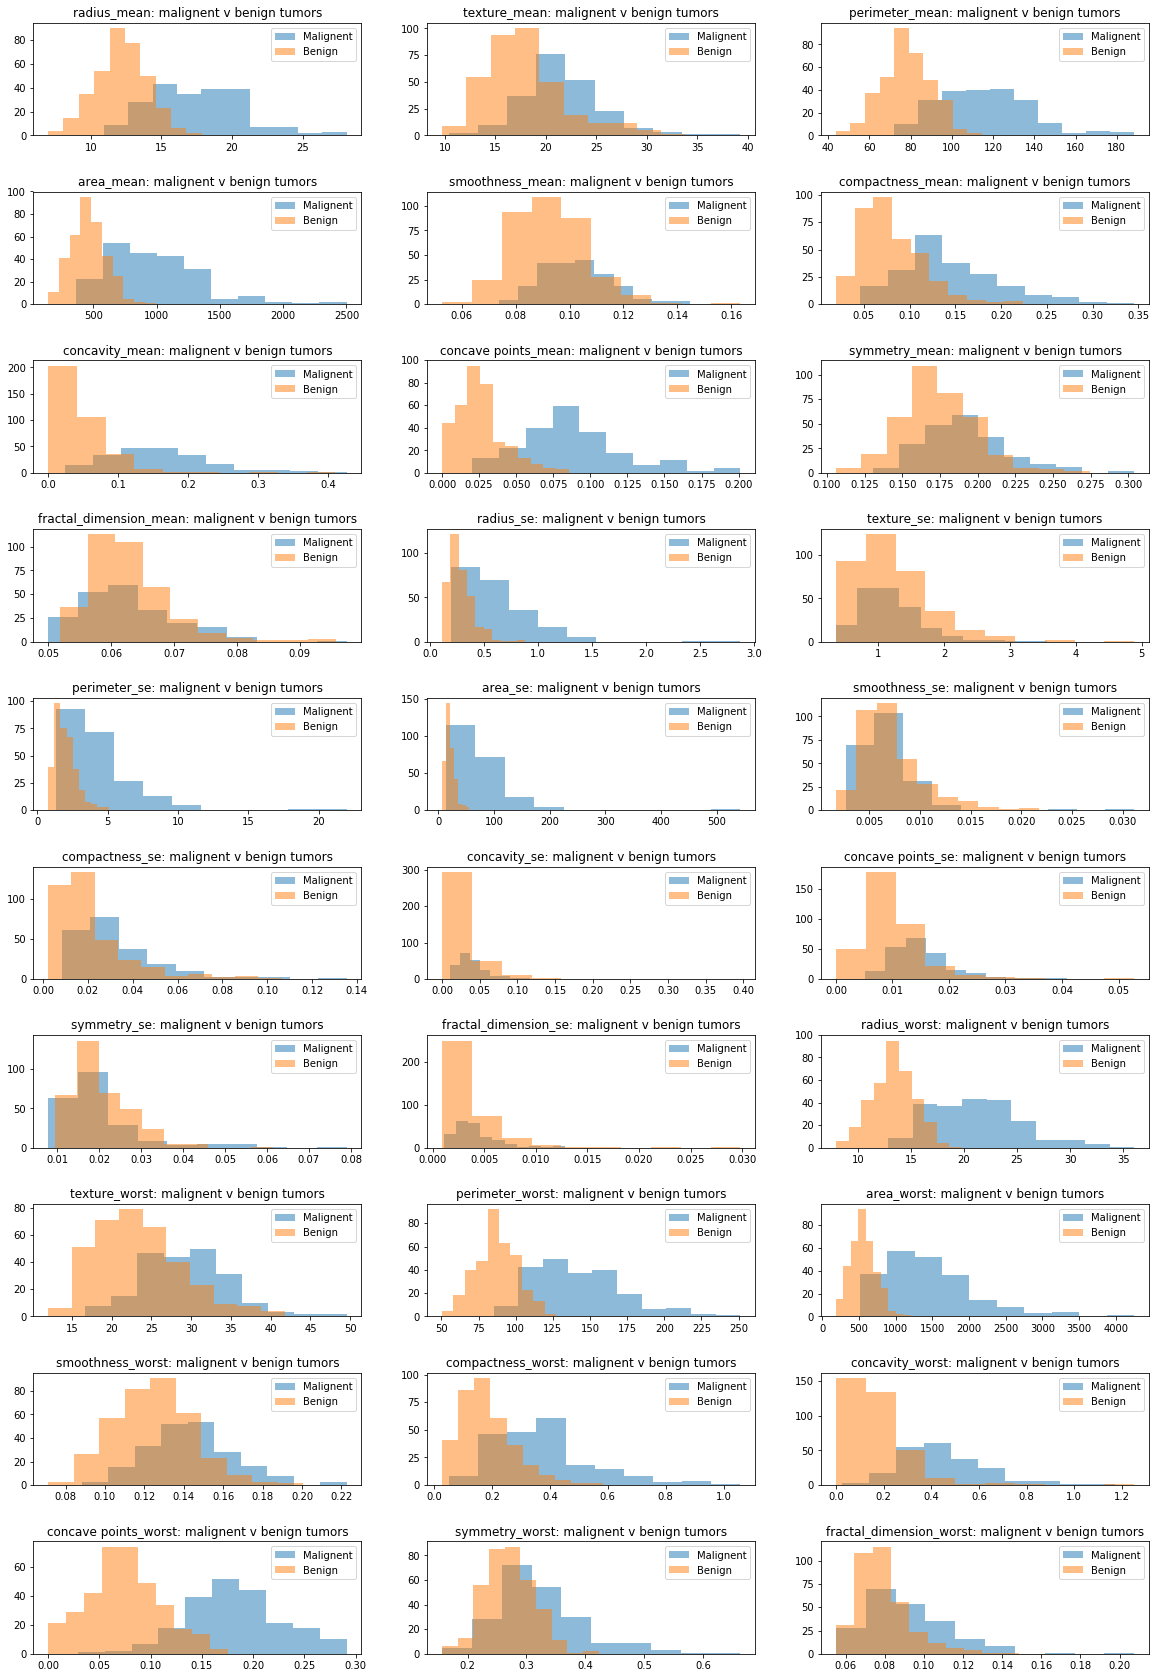

In [109]:
# Function for plotting feature distributions to compare benign & malignent sub-groups
def compare_features_benign_malignent(features, malignent_df, benign_df, rows, cols, figx, figy):
    
    # Define constants
    bins = 10
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figx, figy))
    fig.subplots_adjust(hspace=0.5)
    # For each axes & feature
    for index, (ax, feature) in enumerate(zip(axes.flatten(), features)):
        
        ax.hist(malignent_df[feature], bins, alpha=0.5, label='Malignent')
        ax.hist(benign_df[feature], bins, alpha=0.5, label='Benign')
        ax.legend(loc='upper right')
        ax.set_title(feature + ": malignent v benign tumors")        

# Get feature names (remove first element diagnosis which is target feature)
features = bcancer_clean_df.columns
features = features[1:]
# Plot feature distributions to compare benign & malignent sub-groups
compare_features_benign_malignent(features, malignent_df, benign_df, 10, 3, 20, 30)

So we can see several interesting aspects to the data from these comparitive histograms.

Firstly, there are some features that seem to have a significant difference between the distributions of malignant v benign, these are:

- perimeter_mean
- area_mean
- concave points_mean
- radius_worst
- perimeter_worst
- concave points_worst

These might proove useful features for our model to help better predict & distinguish between and predict malignant v benign tumors. 

Secondly, we can see some of the distributions are particularly skewed i.e. for features:

- radius_se
- perimeter_se
- area_se

These are going to be more difficult for the ML model to work with, so we will probably want to log-transform them to spread out their values more to make the of maximum use to our model.

Thirdly, we can see the units of the features and scale vary widely, with many such as 'symmetry_mean' being fractional decimals below 1, and others such as 'area_worst' has values ranging from a few hundred to over 3500. ML models are very sensitive to these differences of scale so to ensure our model treats all features equally, we will need to normalise them all so each feature is a value between 0 and 1.

Finally more generally we can see comapring the malignant v benign sub-groups accross all features, we can see there are some features where there is clearly much overlap between the groups, and other features where there is a big difference between the values for each groups - so both areas of commonality and difference. 

Let us now move from a univariate perspective to combining multiple features to build up a bigger picture of the dataset.




### Dimensionality reduction using t-SNE and comparing cancer sub-groups

[t-SNE](https://www.datacamp.com/community/tutorials/introduction-t-sne) is a recent dimensionality reduction technique that can be used to compress a multi-dimensional dataset into fewer dimensions while aiming to retain the maximum variance of the original dimensions. 

It is a more recent dimensionality reduction technique, say compared to [PCA](https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2) that has various differences that I will not go into here, but are explored further in an earlier project of mine [here](https://github.com/pranath/high_dim_data_vis).

In this project, I will use t-SNE on this dataset to reduce the dimensionality to 2 & 3 dimensions, and then plot these on scatterplots dividing the data into malignant & benign sub-groups, to see how the values between these sub-groups compare, and see if we can get a better overall picture of how similar or different these sub-groups are.

In [110]:
# Create 2 components using t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(bcancer_clean_df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 33.679842
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.567257
[t-SNE] KL divergence after 300 iterations: 0.274702
t-SNE done! Time elapsed: 1.104383945465088 seconds


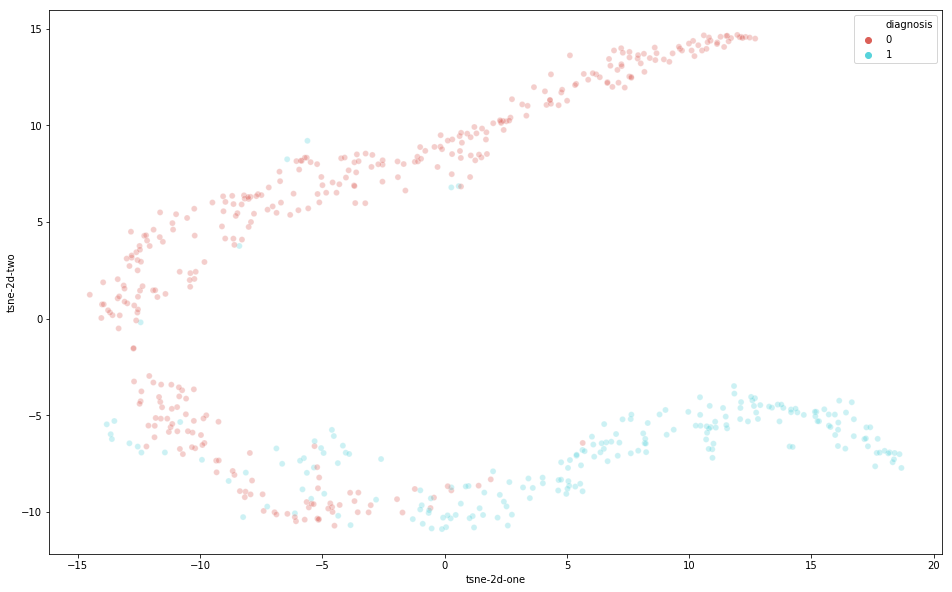

In [111]:
# Plot dataset with 2 t-SNE features, using same colour for data for benign v malignent tumors
bcancer_clean_df['tsne-2d-one'] = tsne_results[:,0]
bcancer_clean_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="diagnosis",
    palette=sns.color_palette("hls", 2),
    data=bcancer_clean_df,
    legend="full",
    alpha=0.3
)

So we can observe various characteristics of the dataset and the subgroups.

We can see that there are clear areas for the benign and malignant groups only, but also common areas of overlap between the two groups.

We can also see an interesting almost symmetrical structure in this side-on 'U' shape. Even for areas of overlap between these two groups, the points follow the same 'U' pattern.

These indicate the potential for a model using the dataset to be able to distinguish between the benign and malignant groups/cases.

Let us now derive 3 t-SNE components from our dataset and plot these.

In [112]:
# Create 3 components using t-SNE
time_start = time.time()
tsne2 = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results2 = tsne2.fit_transform(bcancer_clean_df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 23.814069
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.046417
[t-SNE] KL divergence after 300 iterations: 0.856587
t-SNE done! Time elapsed: 3.351314067840576 seconds


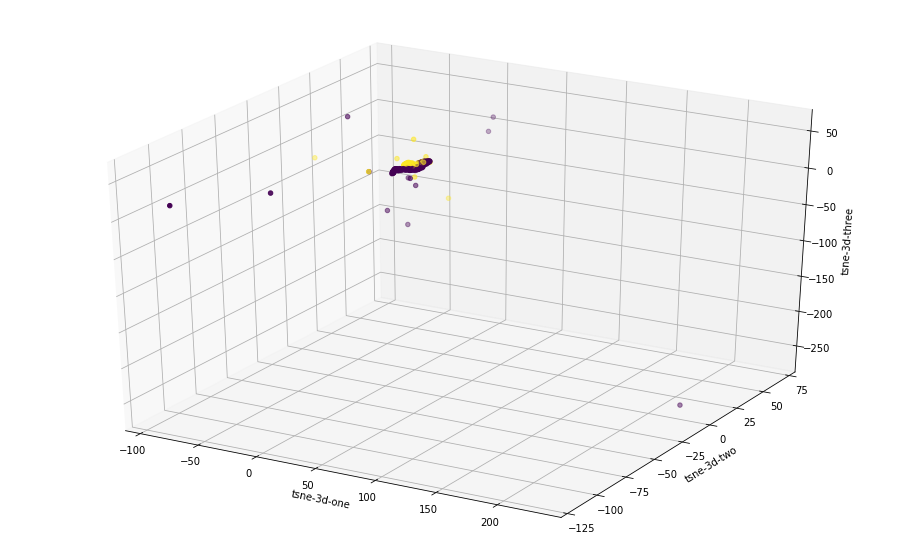

In [113]:
bcancer_clean_df['tsne-3d-one'] = tsne_results2[:,0]
bcancer_clean_df['tsne-3d-two'] = tsne_results2[:,1]
bcancer_clean_df['tsne-3d-three'] = tsne_results2[:,2]
# Plot dataset with 3 t-SNE, using same colour for data for benign v malignent tumors
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=bcancer_clean_df["tsne-3d-one"], 
    ys=bcancer_clean_df["tsne-3d-two"], 
    zs=bcancer_clean_df["tsne-3d-three"], 
    c=bcancer_clean_df["diagnosis"].astype(int)
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

With 3 t-SNE components plotted, bar a few outliers both groups appear to be very close to each other in the space. It is difficult to see here visually exactly how differentiable the benign and malignant groups might be from this plot alone.

Let us just have a quick look at the distributions of the values of these newly generated t-SNE components.

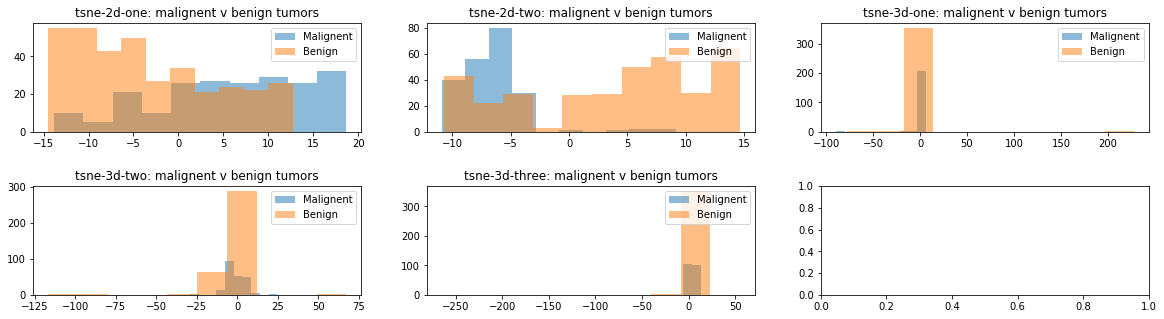

In [114]:
# Plot feature distributions to compare benign & malignent sub-groups for t-sne features
tsne_features = ['tsne-2d-one', 'tsne-2d-two', 'tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three']

# Split dataset into those with malignent and those with benign tumors
malignent_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==1]
benign_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==0]

# Plot feature distributions to compare benign & malignent sub-groups
compare_features_benign_malignent(tsne_features, malignent_df, benign_df, 2, 3, 20, 5)

### Topological data analysis for comparing cancer sub-groups

We will now use a different approach to get a perspective on our data and the differences between the benign and malignant groups - using Topological Data Analysis (TDA). TDA is not a dimensionality reduction technique as such but rather, it produces a more abstract representation of the data (a 'simplicial complex' summary of the original data - an amusing mathematical oxymoron!). This complex could be said to represent the **'shape'** of the data, or a higher order representation of the data.

I have gone over this technique in more detail in a [previous project](https://github.com/pranath/high_dim_data_vis/blob/master/high_dim_data_vis.ipynb) if the reader would like more familiarity with TDA I suggest you refer to that project first. 

In this project, I will apply TDA (using the the [kepler mapper library](https://kepler-mapper.scikit-tda.org/)) to our cancer dataset to see what this more abstract representation of the dataset might reveal about the benign and malignant groups.

There are various technical and hyper-parameter settings that need to be configured to use TDA effectively, as well as a good degree of domain knowledge of the subject matter (in this case Oncology). As I have limited knowledge of both at this point, for guidance with these technical and hyper-parameter settings I have used similar settings to those used in [this](https://github.com/scikit-tda/kepler-mapper/blob/master/examples/breast-cancer/breast-cancer.ipynb) example.

In [115]:
# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(bcancer_clean_df[features])
lens1 = model.decision_function(bcancer_clean_df[features]).reshape((bcancer_clean_df[features].shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(bcancer_clean_df[features], projection="l2norm")

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Define the simplicial complex
graph = mapper.map(lens,
                      bcancer_clean_df[features],
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# Create the visualizations (increased the graph_gravity for a tighter graph-look.)
# Tooltips with the target diagnosis (malignent v benign) for every cluster member
mapper.visualize(graph,
                 title="Topological network of breast cancer data",
                 path_html="tda_breast_cancer.html",
                 color_function=bcancer_clean_df['diagnosis'].values,
                 custom_tooltips=bcancer_clean_df['diagnosis'].values)

/Users/Pranath/.pyenv/versions/3.5.4/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/Pranath/.pyenv/versions/3.5.4/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Topological network of breast cancer data | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  position: absolute;\n  right: 00px;\n  top: 0px;\n  width: 90px;\n  height: 90px;\n  z-index: 999999;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transfo

![title](img/tda_breast_cancer1.png)

The plot above shows the topological network of the dataset, with the malignant group coloured in yellow, the benign group coloured in purple, and the other colours various mixtures of malignant and benign cases.

The plot is actually a fully animated and interactive network that can be explored using your mouse, you can see the full interactive version of the network [here](https://pranath.github.io/breast_cancer_prediction/tda_breast_cancer.html).

In this notebook let us further highlight each of the groups below.

![title](img/tda_breast_cancer2.png)

The topological network of the data reveals some interesting features. Remember that this network is a more abstract and higher level summary of all the features combined, with the malignant and bengin groups coloured.

First, we can see that the benign group is more tightly packed, indicating there is less variance in the values of the features for this group.

Second, and conversely, we can see that the malignant group is far more diverse, incuding many levels of disntinct sub-sub groups within it. This indicates that there is a higher variance in the values of the features for this group.

We can also see there is a mixed group where the two main groups overlap, but this is relatively small.

If we think back to both the example images of malignant v benign cells, as well as the univariate plots of the features this perspective seems to build a consistant picture, beautifully summerised in this topological network.

![title](img/bc_cells.png)

The malignant cells in the images have more variance in their morphology than the bengin cells. The malignant cells are less uniform, less symmetrical, and less homogenous than the benign cells. We can see this dicotomy in many of the corresponding univariate distributions of the measurements of these cells in our features.

This indicates that a ML model might have a good chance of distinguishing well between benign and malignant instances based on the features in the dataset and thus predict each case with a good degree of accuracy.

## Prepare data for ML model

### Log transform skewed features

We identified earier some features that seem particularly skewed (which can be problematic for ML models). Lets log-transform these to try and even thier distributions out.

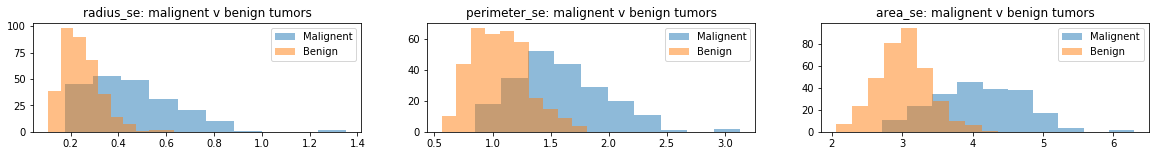

In [117]:
# Log-transform the skewed features
skewed = ['radius_se', 'perimeter_se', 'area_se']
features_log_transformed = pd.DataFrame(data = bcancer_clean_df)
features_log_transformed[skewed] = features_log_transformed[skewed].apply(lambda x: np.log(x + 1))

# Split dataset into those with malignent and those with benign tumors
malignent_log_transformed_df = features_log_transformed[features_log_transformed['diagnosis']==1]
benign_log_transformed_df = features_log_transformed[features_log_transformed['diagnosis']==0]

# Display the distributions of previously skewed features
compare_features_benign_malignent(skewed, malignent_log_transformed_df, benign_log_transformed_df, 1, 3, 20, 2)

Ok the log transform seems to have improved these distributions.

### Normalise all numerical features

We also noticed earlier what differing scales of values each of the features has (which again can be problematic for ML models). Lets normalise the values for all features to be betweeen 0 and 1.

In [118]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numerical_features = features_log_transformed.columns
numerical_features = numerical_features[1:]

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical_features] = scaler.fit_transform(features_log_transformed[numerical_features])

features_log_minmax_transform.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,tsne-2d-one,tsne-2d-two,tsne-3d-one,tsne-3d-two,tsne-3d-three
0,1,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.619292,0.568610,0.912027,0.598462,0.418864,0.923367,0.259824,0.289057,0.598870,0.857757
1,1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.154563,0.192971,0.639175,0.233590,0.222878,0.898479,0.218212,0.286267,0.604902,0.854164
2,1,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.385375,0.359744,0.835052,0.403706,0.213433,0.821036,0.235794,0.293010,0.608937,0.850731
3,1,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.814012,0.548642,0.884880,1.000000,0.773711,0.268163,0.785747,0.266365,0.650881,0.817218
4,1,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.172415,0.319489,0.558419,0.157500,0.142595,0.794181,0.274170,0.292770,0.616846,0.849632


## Metrics and naive predictor

In this section we will define our measure of success for our models and also define a naive predictor to act as a baseline measure.

So in this project, what is most important? we are going to define the key priority as being diagnosing those cases that actually have a malignant tumor most accurately. Of course, as a secondary priority - we do also want to minimise the number of cases where the tumor is actually benign, but we predict it to be malignant.

To get a measure of how well our models are doing for both of these at the same time, we can use the F1 score. We will also calculate an accuarcy score, although the F1 score will be the most important measure. The F1 score is also a good measure to use for our relatively small dataset (570 rows only).

We also want to establish some kind of benchmark to judge our models against, a baseline that we hope to do much better than with our sophisticated ML models! A common baseline is to define a 'naive' predictor - in this case that would be a predictor that classifies all tumors as malignant.

We will now define a naive predictor and calculate an F1 and accuracy score for it - this will be our baseline model and score that we will judge all our other models against.

In [119]:
# Naive predictor
'''
TP = np.sum(features_log_minmax_transform['diagnosis']) # Counting the ones as this is the naive case. 
FP = features_log_minmax_transform['diagnosis'].count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
accuracy = np.sum(features_log_minmax_transform['diagnosis']) / features_log_minmax_transform.shape[0]
recall = 1
precision = accuracy

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta_squared = 0.5 * 0.5
fscore = (1 + beta_squared) * ((precision * recall) / ((beta_squared * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3726, F-score: 0.4260]


## ML model selection & development

For this problem - I have judged the following features are appropriate & desirable in guiding the selection of a machine learning model.

**Model criteria**

- **Memory & speed:** not primarily important but for what is feasible to be run within a notebook in a reasonable time, the aim is assumed to be a one off run of the model to predict rather than a model run continously where significant computational resources might be more an issue. 
- **Not overfitting:** I would regard this as desirable/important, we want a model that generalises well, its going to be run most likely periodically if used and we want to maximise the predictive power each time its run.
- **Time for learning/fitting:** like memory & speed, not so important beyond that which is reasonable to be run in the notebook without the browser timing out!
- **Time for predicting:** again like time for learning/fitting, not so important beyond what can be done in the notebook/browser. However, if we want to deploy and it's useful, we may want to run it on bigger datsets of patient data - so it is a factor worth taking into account.
- **Parameterisation:** slightly important. We will be using grid search later to optimise our solution, this will multiply the computational requirements used for a single model. Given the limit of our computatioal resources available in the notebook/browser a more simple parameterisation would allow the model to scale & deliver within this limited environment for a grid search.
- **Feature tolerance:** not so important, we have just under 40 features and there is no indication these will grow.

With these in mind, these are my selected models, their features - and the rationale for choosing them.

**Model 1 - LogisticRegression**

- **Strengths of model:** Fast to train, no parameter tuning, features don't need scaling, more tolerant to correlated features, excellent for 2-class classification problems
- **Weaknesses of model:** Not so good for large number of features, not good with non-linear decision boundries, not flexible enough to capture more complex relationships, adversely effected by features not relevent to output variable
- **Why model is a good candidate for this problem:** 1. The problem is a binary classification one, logistic regression is one of the best & simplest models for this kind of problem - worth considering occams razor! 2. The computational resources required for this model are low and ensure I can be certain this model will have no problem running in the notebook/browser on this dataset! I would like at least one of my models to be likely to run well with given computational resources. 

**Model 2 - GaussianNB (Gaussian Naive Bayes)**

- **Strengths of model:** Easy and fast to predict class of test data set. If assumption of independence holds reasonably well, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data, also good resistance to missing and noisy data
- **Weaknesses of model:** The assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent, also its hypothesis function is linear, thus it’s very simplistic in most scenarios.
- **Why model is a good candidate for this problem:** 1. This model could be useful if we want to predict on larger datasets for more patients, as it is likely to scale well. 2. Good to evaluate another 'fast' model in addition to logistic regression.

**Model 3 - GradientBoostingClassifier**

- **Strengths of model:** Can handle big datasets, very accurate, can approximate most non-linear classification boundries, one of best boosting models for many classification problems (best in class)
- **Weaknesses of model:** Slow to train (concern over available resources in notebook/browser sufficient?), prone to overfitting, not easy to understand, sensitive to outliers & noisy data, parameterisation can make a real difference to performance - therefore could be more work/fiddly to optimise & get best results.
- **Why model is a good candidate for this problem:** 1. This model is one of the most popular (getting some of the best results) models for classification problems - worth serious consideration! 2. Paramaterisation can make a real difference to performance with this model, good chance of improvement in optimisation/grid search phase for one of the best solutions (assuming computational resources of notebook/browser sufficient).

References

I found the following tables & cheatsheets particularly useful in selecting my models:

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

https://blogs.sas.com/content/subconsciousmusings/2017/04/12/machine-learning-algorithm-use/

https://www.dataschool.io/comparing-supervised-learning-algorithms/

https://recast.ai/blog/machine-learning-algorithms/2/

We will now split our dataset into training and testing subsets, and develop functions that will act as a training & testing pipleline, as well as displaying the results from all our models.

In [120]:
# Split data into train & test
X = features_log_minmax_transform[numerical_features]
y = features_log_minmax_transform['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)                                                                                                                                                                                              

In [122]:
# Define function that will act as pipeline for training and testing our models (and returning the results)
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time.time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time.time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time.time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [143]:
# Define function that will take the results of our model training & testing and plot the results
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.

    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """

    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (13,9))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["10%", "50%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")

    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")

    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()


In [123]:
# Initialize the three models
clf_A = linear_model.LogisticRegression()
clf_B = GaussianNB()
clf_C = GradientBoostingClassifier()

# Calculate the number of samples for 10%, 50% and 100% of the training data
samples_100 = len(y_train)
samples_50 = int((samples_100 / 100) * 50)
samples_10 = int((samples_100 / 100) * 10)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_10, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 45 samples.
LogisticRegression trained on 227 samples.
LogisticRegression trained on 455 samples.
GaussianNB trained on 45 samples.
GaussianNB trained on 227 samples.
GaussianNB trained on 455 samples.
GradientBoostingClassifier trained on 45 samples.


/Users/Pranath/.pyenv/versions/3.5.4/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Pranath/.pyenv/versions/3.5.4/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Pranath/.pyenv/versions/3.5.4/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GradientBoostingClassifier trained on 227 samples.
GradientBoostingClassifier trained on 455 samples.


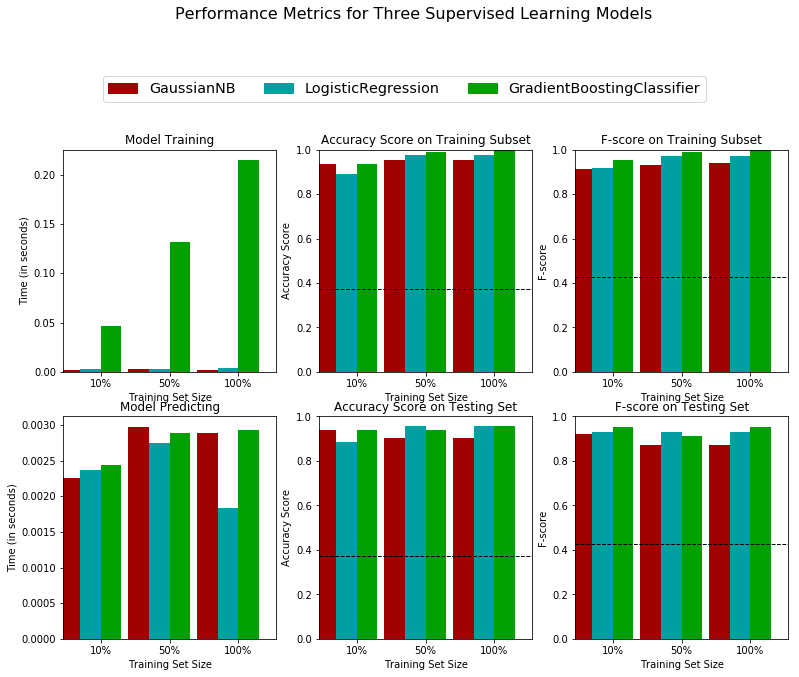

In [144]:
# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

We can observe the results of our model training and evaluation in the above plots of the metric scores for each model type.

Firstly we can see that all 3 models have done quite well, with all models getting at least 0.80 on the testing dataset, even when only 10% or 50% of that testing set was used.

For the model training, we can see that the GradientBoostingClassifier took by far the most time to train, and in terms of speed of predicting unsurprisingly LogisticRegression was the fastest. However, in terms of the key metric using 100% of the test dataset, we can see that the GradientBoostingClassifier seems to perform the best.

Therefore we will select the GradientBoostingClassifier as our best model and the one we want to optimise going forward.

### Model tuning

We will now use a GradientBoostingClassifier to optimse using grid search on various hyper-parameters, using F1 score as the scorer.

In [146]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=0)

# Create the parameters we want to tune
parameters = {'n_estimators': [10, 50, 300], 'learning_rate': [0.1], 'max_depth': [6], 'min_samples_split': [100], 'warm_start': [True], 'subsample': [0.8], 'min_samples_leaf': [40]} 
    
# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print(grid_fit.best_estimator_.get_params)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/Users/Pranath/.pyenv/versions/3.5.4/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=40, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)>
Unoptimized model
------
Accuracy score on testing data: 0.9649
F-score on testing data: 0.9574

Optimized Model
------
Final accuracy score on the testing data: 0.9912
Final F-score on the testing data: 0.9957


## ML model evaluation

## Feature importance

In [149]:
def feature_plot(importances, X_train, y_train):

    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)

    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

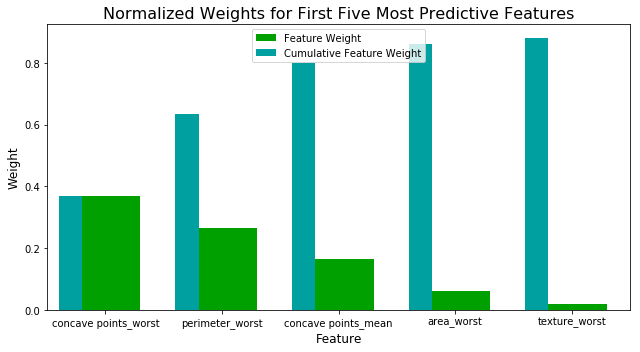

In [150]:
# Extract the feature importances 
importances = best_clf.feature_importances_ 

# Plot
feature_plot(importances, X_train, y_train)

## Conclusion